In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sys 
import os
sys.path.append(os.path.abspath("../src"))

import functions as fnc

plt.style.use('tableau-colorblind10')

In [2]:
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [3]:
train_train = pd.read_csv("../data/processed/train_train.csv")
train_test = pd.read_csv("../data/processed/train_test.csv")
test = pd.read_csv("../data/processed/test.csv")

correlations = pd.read_csv('../data/processed/correlations.csv')

In [4]:
correlations.set_index('Unnamed: 0', inplace=True
                      )

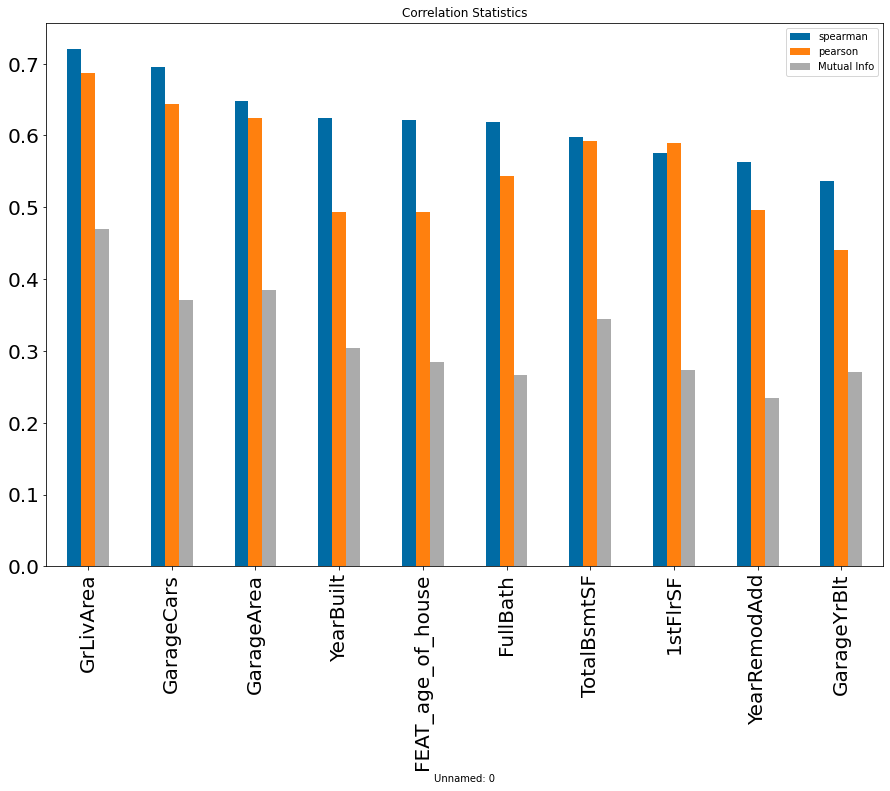

In [76]:
correlations.sort_values(by='spearman', ascending = False)[:10][['spearman', 'pearson', 'Mutual Info']].plot.bar(figsize= (15,10));
plt.title('Correlation Statistics');
ax = plt.gca();
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)


In [5]:
correlations.drop('SalePrice', inplace=True)

## model with all features

In [6]:
model_result_stats = pd.DataFrame()

### lr

In [7]:
lr = LinearRegression()
lr.fit(train_train[correlations.index.to_list()], train_train['SalePrice'] )

LinearRegression()

<AxesSubplot:ylabel='Frequency'>

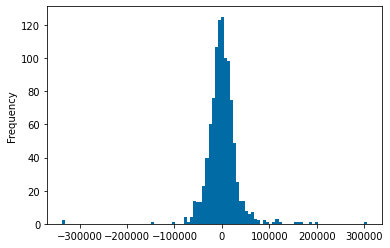

In [8]:
(train_train['SalePrice'] - lr.predict(train_train[correlations.index.to_list()])).plot(kind='hist', bins= 100)

In [9]:
def get_stats(preds_train, preds_test, target_train,target_test, n_features= None):
    
    r2_train = r2_score(target_train, preds_train )
    r2_test = r2_score(target_test, preds_test)
    
    if n_features:
        r2_adj_test = 1- (1-r2_test)*((len(preds_test)-1) / (len(preds_test) - n_features - 1))
        r2_adj_train = 1- (1-r2_train)*((len(preds_train)-1) / (len(preds_train) - n_features - 1))
        
    rmse_train = mean_squared_error(target_train, preds_train)**0.5
    rmse_test = mean_squared_error(target_test, preds_test)**0.5
    
    mse_train = mean_squared_error(target_train, preds_train)
    mse_test = mean_squared_error(target_test, preds_test)
    
    mae_train = mean_absolute_error(target_train, preds_train)
    mae_test = mean_absolute_error(target_test, preds_test)
    
    result_train = {'r2': r2_train, 'rmse': rmse_train, 'train_test':'train', 'mse': mse_train, 'mae': mae_train}
    result_test = {'r2': r2_test, 'rmse': rmse_test, 'train_test':'test', 'mse': mse_test, 'mae': mae_test}
    if n_features:
        result_train['r2_adj'] = r2_adj_train
        result_test['r2_adj'] = r2_adj_test
    return [result_train, result_test]



In [10]:
lr_stats = pd.DataFrame(get_stats(lr.predict(train_train[correlations.index.to_list()]),  
                                  lr.predict(train_test[correlations.index.to_list()]),
                                  train_train['SalePrice'], 
                                  train_test['SalePrice'],
                                  len(correlations.index.to_list() )))


lr_stats['model'] = 'lr'
lr_stats['feature_subset'] = 'all'

In [11]:
model_result_stats = model_result_stats.append(lr_stats)

/var/folders/6f/qt7yx3mj0cb712hd40l3ggnr0000gn/T/ipykernel_10024/409294684.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_result_stats = model_result_stats.append(lr_stats)


### xgb

In [84]:
xgb_reg = XGBRegressor(n_estimators= 500, 
                       max_depth=3, 
                       learning_rate= 0.01, 
                       colsample_bytree= 0.6, 
                       random_state= 123, verbosity= 1)

In [85]:
xgb_reg.fit(train_train[correlations.index.to_list()], train_train['SalePrice'])

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.6,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=500, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=123,
             reg_alpha=0, reg_lambda=1, ...)

In [86]:
xgb_reg.predict(train_train[correlations.index.to_list()])

array([128008.73, 209381.27, 225432.08, ..., 112290.43, 200308.2 ,
       115819.3 ], dtype=float32)

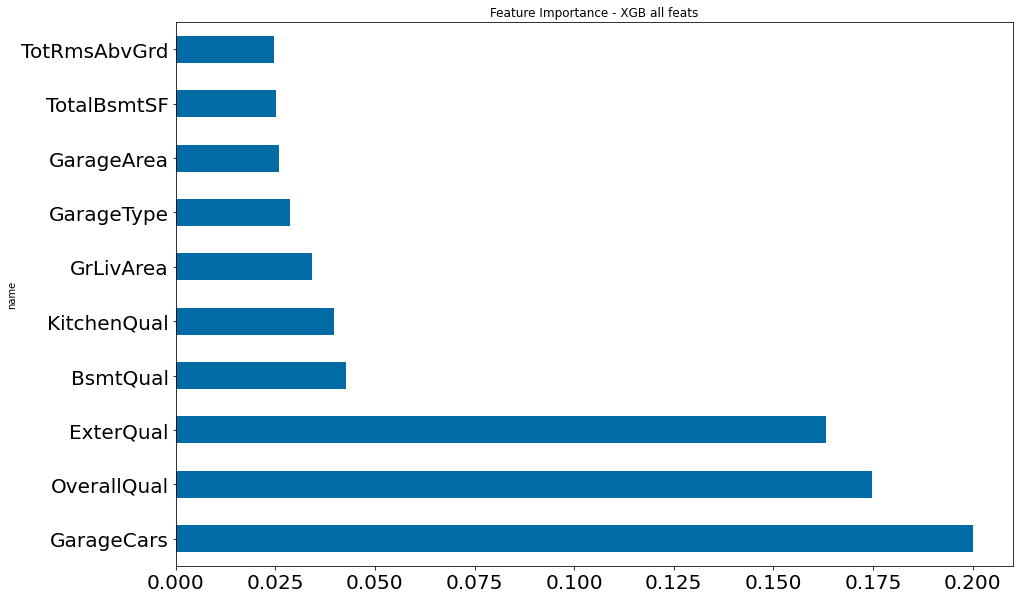

In [101]:
feat_imps = pd.DataFrame(zip(correlations.index.to_list(), xgb_reg.feature_importances_))
feat_imps.columns = ['name', 'importance']
feat_imps.sort_values(by= 'importance', ascending=False).set_index('name')[:10].plot(kind='barh', figsize = (15,10));
plt.title('Feature Importance - XGB all feats');
ax = plt.gca();
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
ax.get_legend().remove()

Text(0.5, 1.0, 'Feature importances - XGB all Features')

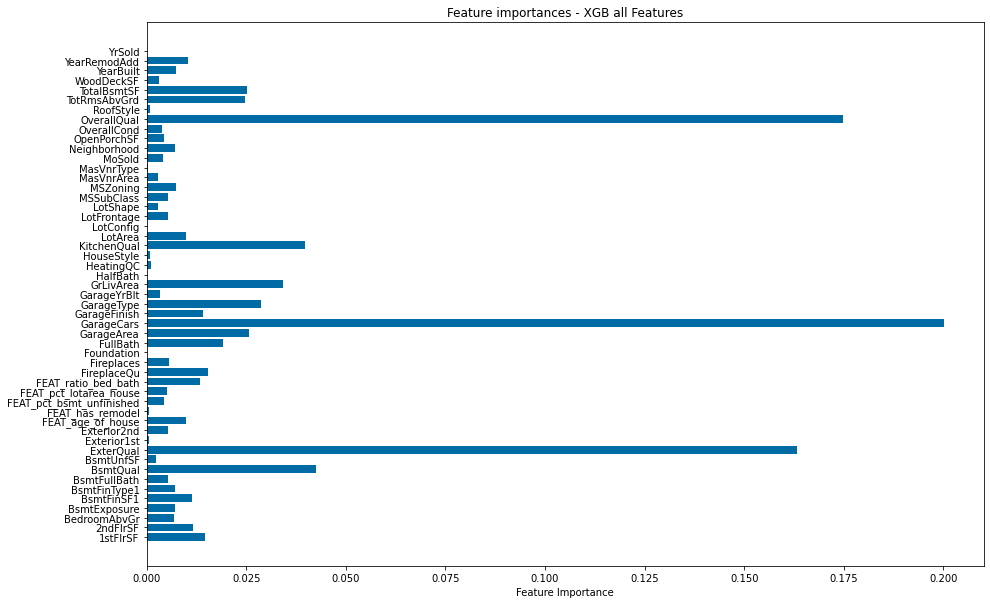

In [92]:
plt.figure(figsize=(15,10))
plt.barh(correlations.index.to_list(), xgb_reg.feature_importances_)
plt.xlabel('Feature Importance')
plt.title('Feature importances - XGB all Features');

In [87]:
_stats = pd.DataFrame(get_stats(xgb_reg.predict(train_train[correlations.index.to_list()]),  
                                  xgb_reg.predict(train_test[correlations.index.to_list()]),
                                  train_train['SalePrice'], 
                                  train_test['SalePrice'],
                                  len(correlations.index.to_list() )))


_stats['model'] = 'xgb'
_stats['feature_subset'] = 'all'

In [16]:
model_result_stats = model_result_stats.append(_stats, ignore_index=True)

/var/folders/6f/qt7yx3mj0cb712hd40l3ggnr0000gn/T/ipykernel_10024/3430816571.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_result_stats = model_result_stats.append(_stats, ignore_index=True)


In [17]:
model_result_stats

,r2,rmse,train_test,mse,mae,r2_adj,model,feature_subset
0,0.822218,33690.093924,train,1.135022e+09,20691.288162,0.812871,lr,all
1,0.863984,28864.480096,test,8.331582e+08,20026.688650,0.846013,lr,all
2,0.947470,18313.074452,train,3.353687e+08,12909.785657,0.944708,xgb,all
3,0.906433,23940.376459,test,5.731416e+08,15087.182256,0.894070,xgb,all


### rf

In [18]:
rf_reg = RandomForestRegressor(n_estimators = 500, max_depth=5, min_samples_leaf=5, random_state= 123,)

In [19]:
rf_reg.fit(train_train[correlations.index.to_list()], train_train['SalePrice'])

RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=500,
                      random_state=123)

In [20]:
_stats = pd.DataFrame(get_stats(rf_reg.predict(train_train[correlations.index.to_list()]),  
                                  rf_reg.predict(train_test[correlations.index.to_list()]),
                                  train_train['SalePrice'], 
                                  train_test['SalePrice'],
                                  len(correlations.index.to_list() )))


_stats['model'] = 'rf'
_stats['feature_subset'] = 'all'

model_result_stats = model_result_stats.append(_stats, ignore_index=True)

/var/folders/6f/qt7yx3mj0cb712hd40l3ggnr0000gn/T/ipykernel_10024/3235683367.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_result_stats = model_result_stats.append(_stats, ignore_index=True)


In [21]:
model_result_stats.sort_values(by='rmse')

,r2,rmse,train_test,mse,mae,r2_adj,model,feature_subset
2,0.947470,18313.074452,train,3.353687e+08,12909.785657,0.944708,xgb,all
3,0.906433,23940.376459,test,5.731416e+08,15087.182256,0.894070,xgb,all
4,0.896523,25702.818695,train,6.606349e+08,16880.991093,0.891082,rf,all
5,0.871366,28070.301095,test,7.879418e+08,18120.345565,0.854370,rf,all
1,0.863984,28864.480096,test,8.331582e+08,20026.688650,0.846013,lr,all
0,0.822218,33690.093924,train,1.135022e+09,20691.288162,0.812871,lr,all


## model with top 10 spearman

In [22]:
model_feats = correlations.sort_values(by='spearman', ascending=False)[:10].index.to_list()

In [23]:
lr.fit(train_train[model_feats], train_train['SalePrice'] )
rf_reg.fit(train_train[model_feats], train_train['SalePrice'])
xgb_reg.fit(train_train[model_feats], train_train['SalePrice'] )


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.6,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=500, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=123,
             reg_alpha=0, reg_lambda=1, ...)

In [24]:
_stats = pd.DataFrame(get_stats(lr.predict(train_train[model_feats]),  
                                  lr.predict(train_test[model_feats]),
                                  train_train['SalePrice'], 
                                  train_test['SalePrice'],
                                  len(correlations.index.to_list() )))


_stats['model'] = 'lr'
_stats['feature_subset'] = 'top10_spearman'

model_result_stats = model_result_stats.append(_stats, ignore_index=True)

/var/folders/6f/qt7yx3mj0cb712hd40l3ggnr0000gn/T/ipykernel_10024/3612970605.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_result_stats = model_result_stats.append(_stats, ignore_index=True)


In [25]:
_stats = pd.DataFrame(get_stats(rf_reg.predict(train_train[model_feats]),  
                                  rf_reg.predict(train_test[model_feats]),
                                  train_train['SalePrice'], 
                                  train_test['SalePrice'],
                                  len(correlations.index.to_list() )))


_stats['model'] = 'rf'
_stats['feature_subset'] = 'top10_spearman'

model_result_stats = model_result_stats.append(_stats, ignore_index=True)

/var/folders/6f/qt7yx3mj0cb712hd40l3ggnr0000gn/T/ipykernel_10024/4136735433.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_result_stats = model_result_stats.append(_stats, ignore_index=True)


In [26]:
_stats = pd.DataFrame(get_stats(xgb_reg.predict(train_train[model_feats]),  
                                  xgb_reg.predict(train_test[model_feats]),
                                  train_train['SalePrice'], 
                                  train_test['SalePrice'],
                                  len(correlations.index.to_list() )))


_stats['model'] = 'xgb'
_stats['feature_subset'] = 'top10_spearman'

model_result_stats = model_result_stats.append(_stats, ignore_index=True)

/var/folders/6f/qt7yx3mj0cb712hd40l3ggnr0000gn/T/ipykernel_10024/2447992907.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_result_stats = model_result_stats.append(_stats, ignore_index=True)


## model with top 10 mutual info

In [27]:
model_feats = correlations.sort_values(by='Mutual Info', ascending=False)[:10].index.to_list()

In [28]:
lr.fit(train_train[model_feats], train_train['SalePrice'] )
rf_reg.fit(train_train[model_feats], train_train['SalePrice'])
xgb_reg.fit(train_train[model_feats], train_train['SalePrice'] )


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.6,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=500, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=123,
             reg_alpha=0, reg_lambda=1, ...)

In [29]:
_stats = pd.DataFrame(get_stats(lr.predict(train_train[model_feats]),  
                                  lr.predict(train_test[model_feats]),
                                  train_train['SalePrice'], 
                                  train_test['SalePrice'],
                                  len(correlations.index.to_list() )))


_stats['model'] = 'lr'
_stats['feature_subset'] = 'top10_mutual_info'

model_result_stats = model_result_stats.append(_stats, ignore_index=True)

/var/folders/6f/qt7yx3mj0cb712hd40l3ggnr0000gn/T/ipykernel_10024/1700783271.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_result_stats = model_result_stats.append(_stats, ignore_index=True)


In [30]:
_stats = pd.DataFrame(get_stats(rf_reg.predict(train_train[model_feats]),  
                                  rf_reg.predict(train_test[model_feats]),
                                  train_train['SalePrice'], 
                                  train_test['SalePrice'],
                                  len(correlations.index.to_list() )))


_stats['model'] = 'rf'
_stats['feature_subset'] = 'top10_mutual_info'

model_result_stats = model_result_stats.append(_stats, ignore_index=True)

/var/folders/6f/qt7yx3mj0cb712hd40l3ggnr0000gn/T/ipykernel_10024/766410907.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_result_stats = model_result_stats.append(_stats, ignore_index=True)


In [31]:
_stats = pd.DataFrame(get_stats(xgb_reg.predict(train_train[model_feats]),  
                                  xgb_reg.predict(train_test[model_feats]),
                                  train_train['SalePrice'], 
                                  train_test['SalePrice'],
                                  len(correlations.index.to_list() )))


_stats['model'] = 'xgb'
_stats['feature_subset'] = 'top10_mutual_info'

model_result_stats = model_result_stats.append(_stats, ignore_index=True)

/var/folders/6f/qt7yx3mj0cb712hd40l3ggnr0000gn/T/ipykernel_10024/2371897527.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_result_stats = model_result_stats.append(_stats, ignore_index=True)


## model with top 10 pearson

In [32]:
model_feats = correlations.sort_values(by='pearson', ascending=False)[:10].index.to_list()

In [33]:
lr.fit(train_train[model_feats], train_train['SalePrice'] )
rf_reg.fit(train_train[model_feats], train_train['SalePrice'])
xgb_reg.fit(train_train[model_feats], train_train['SalePrice'] )


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.6,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=500, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=123,
             reg_alpha=0, reg_lambda=1, ...)

In [34]:
_stats = pd.DataFrame(get_stats(lr.predict(train_train[model_feats]),  
                                  lr.predict(train_test[model_feats]),
                                  train_train['SalePrice'], 
                                  train_test['SalePrice'],
                                  len(correlations.index.to_list() )))


_stats['model'] = 'lr'
_stats['feature_subset'] = 'top10_pearson'

model_result_stats = model_result_stats.append(_stats, ignore_index=True)

/var/folders/6f/qt7yx3mj0cb712hd40l3ggnr0000gn/T/ipykernel_10024/1623738712.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_result_stats = model_result_stats.append(_stats, ignore_index=True)


In [35]:
_stats = pd.DataFrame(get_stats(rf_reg.predict(train_train[model_feats]),  
                                  rf_reg.predict(train_test[model_feats]),
                                  train_train['SalePrice'], 
                                  train_test['SalePrice'],
                                  len(correlations.index.to_list() )))


_stats['model'] = 'rf'
_stats['feature_subset'] = 'top10_pearson'

model_result_stats = model_result_stats.append(_stats, ignore_index=True)

/var/folders/6f/qt7yx3mj0cb712hd40l3ggnr0000gn/T/ipykernel_10024/3882271914.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_result_stats = model_result_stats.append(_stats, ignore_index=True)


In [36]:
_stats = pd.DataFrame(get_stats(xgb_reg.predict(train_train[model_feats]),  
                                  xgb_reg.predict(train_test[model_feats]),
                                  train_train['SalePrice'], 
                                  train_test['SalePrice'],
                                  len(correlations.index.to_list() )))


_stats['model'] = 'xgb'
_stats['feature_subset'] = 'top10_pearson'

model_result_stats = model_result_stats.append(_stats, ignore_index=True)

/var/folders/6f/qt7yx3mj0cb712hd40l3ggnr0000gn/T/ipykernel_10024/983568388.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_result_stats = model_result_stats.append(_stats, ignore_index=True)


In [40]:
model_result_stats

,r2,rmse,train_test,mse,mae,r2_adj,model,feature_subset
0,0.822218,33690.093924,train,1.135022e+09,20691.288162,0.812871,lr,all
1,0.863984,28864.480096,test,8.331582e+08,20026.688650,0.846013,lr,all
2,0.947470,18313.074452,train,3.353687e+08,12909.785657,0.944708,xgb,all
3,0.906433,23940.376459,test,5.731416e+08,15087.182256,0.894070,xgb,all
4,0.896523,25702.818695,train,6.606349e+08,16880.991093,0.891082,rf,all
5,0.871366,28070.301095,test,7.879418e+08,18120.345565,0.854370,rf,all
6,0.705896,43332.043463,train,1.877666e+09,26974.569255,0.690433,lr,top10_spearman
7,0.785876,36216.132121,test,1.311608e+09,24467.652345,0.757585,lr,top10_spearman
8,0.842124,31747.980800,train,1.007934e+09,20927.340890,0.833824,rf,top10_spearman
9,0.817105,33471.090544,test,1.120314e+09,21488.712582,0.792940,rf,top10_spearman


In [42]:
r2_stats = model_result_stats[model_result_stats['train_test'] == 'test'].sort_values(by='r2', ascending=False)

In [43]:
r2_stats

,r2,rmse,train_test,mse,mae,r2_adj,model,feature_subset
3,0.906433,23940.376459,test,5.731416e+08,15087.182256,0.894070,xgb,all
5,0.871366,28070.301095,test,7.879418e+08,18120.345565,0.854370,rf,all
1,0.863984,28864.480096,test,8.331582e+08,20026.688650,0.846013,lr,all
17,0.853170,29990.054116,test,8.994033e+08,19651.001819,0.833770,xgb,top10_mutual_info
23,0.849873,30324.843120,test,9.195961e+08,19679.868668,0.830038,xgb,top10_pearson
11,0.848717,30441.411362,test,9.266795e+08,19855.536084,0.828728,xgb,top10_spearman
15,0.819351,33264.923361,test,1.106555e+09,21503.905955,0.795483,rf,top10_mutual_info
21,0.818463,33346.584111,test,1.111995e+09,21444.809275,0.794478,rf,top10_pearson
9,0.817105,33471.090544,test,1.120314e+09,21488.712582,0.792940,rf,top10_spearman
7,0.785876,36216.132121,test,1.311608e+09,24467.652345,0.757585,lr,top10_spearman


In [83]:
model_result_stats[model_result_stats.feature_subset == 'all'].set_index('model').round(2).to_clipboard()

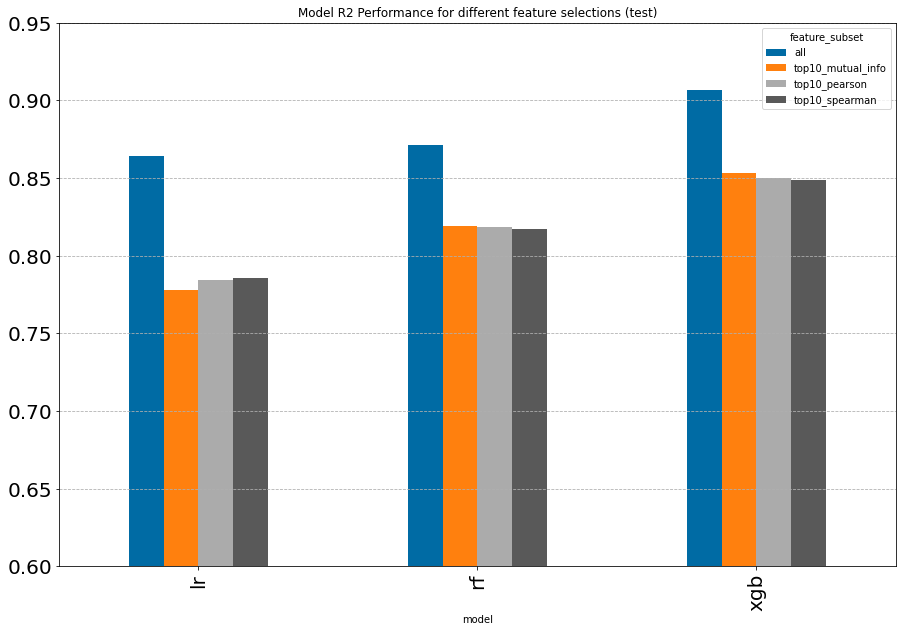

In [77]:
r2_stats.pivot(index='model', 
               columns = 'feature_subset', 
               values='r2').plot.bar(figsize= (15,10), 
                                     title= 'Model R2 Performance for different feature selections (test)')
ax = plt.gca()
plt.ylim(0.6,0.95)
ax.grid(which='major', axis='y', linestyle='--');

ax = plt.gca();
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)


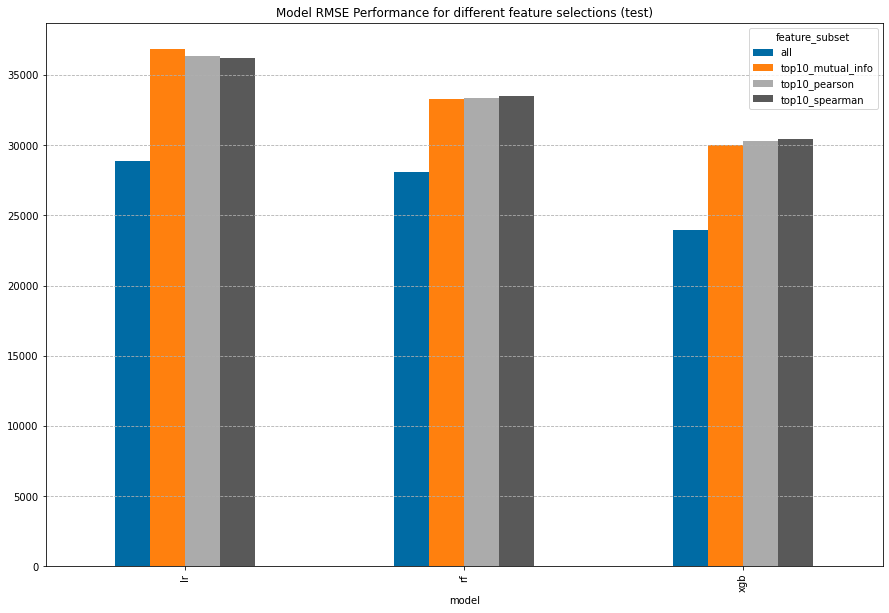

In [63]:
r2_stats.pivot(index='model', 
               columns = 'feature_subset', 
               values='rmse').plot.bar(figsize= (15,10), 
                                     title= 'Model RMSE Performance for different feature selections (test)')
ax = plt.gca()
#plt.ylim(0.6,0.95)
ax.grid(which='major', axis='y', linestyle='--');